In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load the training data. Split into training 80% and validation 20%.

### Labels:
* 'buildings' -> 0,
* 'forest' -> 1,
* 'glacier' -> 2,
* 'mountain' -> 3,
* 'sea' -> 4,
* 'street' -> 5

### Original without augmentation.

In [2]:
trainDirectory = '../input/csc-578-hw7-fall-2023/train'

imgHeight = 150
imgWidth = 150

trainData, validationData = tf.keras.utils.image_dataset_from_directory(
    trainDirectory,
    labels='inferred',        #Use names of subdirectories as target labels.
    label_mode='categorical', #Convert target class (int) to one-hot-vector.
    validation_split=0.2,
    subset="both",
    seed=123,                 #Use same random seed with valid_set
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(imgHeight, imgWidth),)

Found 13986 files belonging to 6 classes.
Using 11189 files for training.
Using 2797 files for validation.


### Visualize some training examples. Not with augmentation. 

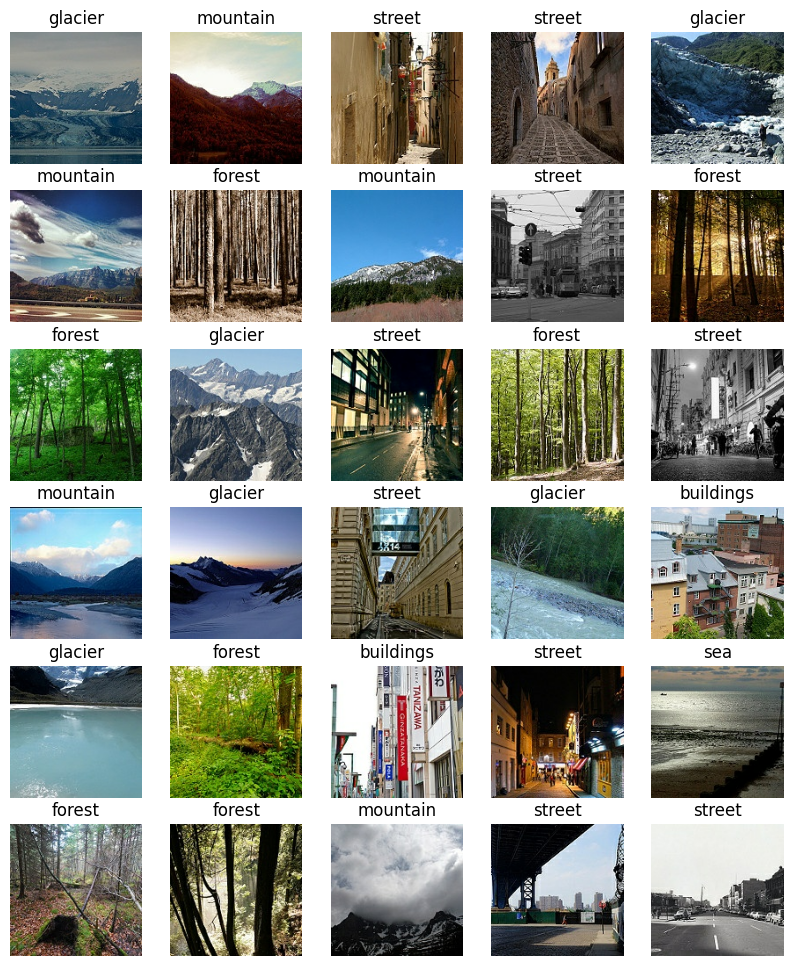

In [3]:
plt.figure(figsize=(10, 12))
classNames = trainData.class_names
for images, labels in trainData.take(1):
    for i in range(30):
        ax = plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classNames[np.argmax(labels[i])])
        plt.axis("off")

### 1st attempt augmentation - using ImageDataGenerator.

In [4]:
imgHeight = 150
imgWidth = 150

#Create an instance of the ImageDataGenerator with augmentation parameters.
aug = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=10,
    horizontal_flip=True,
    rescale=1.0/255,
    validation_split=0.2)

trainAug = aug.flow_from_directory(
    '../input/csc-578-hw7-fall-2023/train',
    batch_size=32,
    seed=123,
    class_mode='categorical', 
    subset='training', 
    color_mode='rgb',
    target_size=(imgHeight, imgWidth))

validationAug = aug.flow_from_directory(
    '../input/csc-578-hw7-fall-2023/train',
    batch_size=32,
    seed=123,
    class_mode='categorical',  
    subset='validation',
    color_mode='rgb',
    target_size=(imgHeight, imgWidth))

Found 11190 images belonging to 6 classes.
Found 2796 images belonging to 6 classes.


### 1st attempt augmentation - Visualize some training examples. 

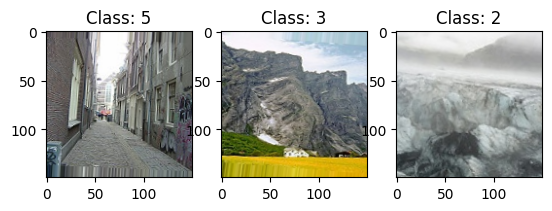

In [5]:
batchImages, batchLabels = validationAug.next()

#Visualize the first few images in the batch.
numImages = 3
for i in range(numImages):
    image = batchImages[i]
    label = batchLabels[i]

    #Display the image
    plt.subplot(1, numImages, i + 1)
    plt.imshow(image)
    plt.title(f'Class: {label.argmax()}') 

plt.show()

### 2nd attempt augmentation - using Keras RandomFlip and RandomRotation.

In [6]:
aug2 = keras.Sequential([
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),])

#Make copies.
trainData2 = trainData
validationData2 = validationData

### 2nd attempt augmentation - Visualize some training examples. 

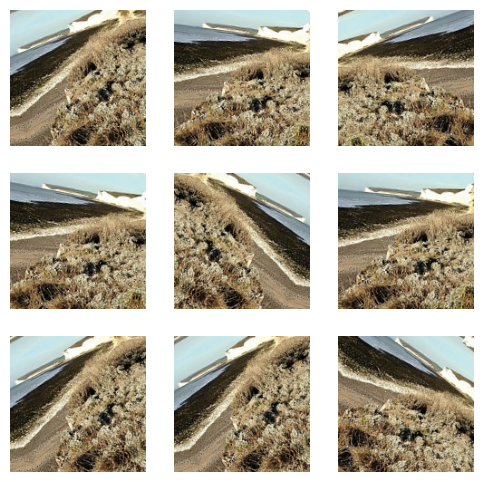

In [7]:
plt.figure(figsize=(6, 6))
for images, _ in trainData2.take(2):
    for i in range(9):
        augmentedImages = aug2(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmentedImages[0].numpy().astype("uint8"))
        plt.axis("off")

### 2nd attempt augmentation - Apply `aug2` to the training images.

In [8]:
trainData2 = trainData2.map(
    lambda img, label: (aug2(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,)

#Prefetching samples in GPU memory helps maximize GPU utilization.
trainData2 = trainData2.prefetch(tf.data.AUTOTUNE)
validationData2 = validationData2.prefetch(tf.data.AUTOTUNE)

### Original model.

In [9]:
#A relatively simple CNN model
model = keras.Sequential()
#Scales the pixel values of input images to the range [0, 1]. input_shape parameter specifies the size.
model.add(keras.layers.Rescaling(1./255, input_shape=(imgHeight, imgWidth,3)))

#CV1 with 16 filters, each of size of 3x3. ReLU activation function.
model.add(keras.layers.Conv2D(16, (3,3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D(2,2))

#CV2 with 32 filters, each of size of 3x3. ReLU activation function.
model.add(keras.layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D(2,2))

#Last pooling layer is flattened to a 1D vector.
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(6, activation='softmax'))

#Compile model.
opt = Adam(learning_rate = 0.001)  #Set learning rate. 
model.compile(optimizer=opt, loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [10]:
# Print model summary to ensure
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)            

In [11]:
#Fit original model on non-augmented data.
historyOriginal_nonAug = model.fit(trainData, epochs=5, validation_data=validationData)

Epoch 1/5
350/350 [==============================] - 11s 20ms/step - loss: 0.9622 - accuracy: 0.6552 - val_loss: 0.7314 - val_accuracy: 0.7379
Epoch 2/5
350/350 [==============================] - 6s 18ms/step - loss: 0.5277 - accuracy: 0.8115 - val_loss: 0.7369 - val_accuracy: 0.7458
Epoch 3/5
350/350 [==============================] - 7s 18ms/step - loss: 0.2736 - accuracy: 0.9076 - val_loss: 0.7197 - val_accuracy: 0.7622
Epoch 4/5
350/350 [==============================] - 7s 19ms/step - loss: 0.1231 - accuracy: 0.9634 - val_loss: 0.8199 - val_accuracy: 0.7597
Epoch 5/5
350/350 [==============================] - 6s 18ms/step - loss: 0.0596 - accuracy: 0.9846 - val_loss: 0.9624 - val_accuracy: 0.7458


In [12]:
#Fit original model on augmented data.
historyOriginal_Aug = model.fit(trainData2, epochs=5, validation_data=validationData2)

Epoch 1/5
350/350 [==============================] - 14s 41ms/step - loss: 0.8770 - accuracy: 0.6744 - val_loss: 0.7493 - val_accuracy: 0.7326
Epoch 2/5
350/350 [==============================] - 15s 42ms/step - loss: 0.7380 - accuracy: 0.7329 - val_loss: 0.7067 - val_accuracy: 0.7540
Epoch 3/5
350/350 [==============================] - 14s 40ms/step - loss: 0.7227 - accuracy: 0.7339 - val_loss: 0.6514 - val_accuracy: 0.7669
Epoch 4/5
350/350 [==============================] - 15s 41ms/step - loss: 0.6719 - accuracy: 0.7534 - val_loss: 0.7659 - val_accuracy: 0.7319
Epoch 5/5
350/350 [==============================] - 14s 40ms/step - loss: 0.6321 - accuracy: 0.7716 - val_loss: 0.7698 - val_accuracy: 0.7404


### Original model - Visualize Training (accuracy and loss).

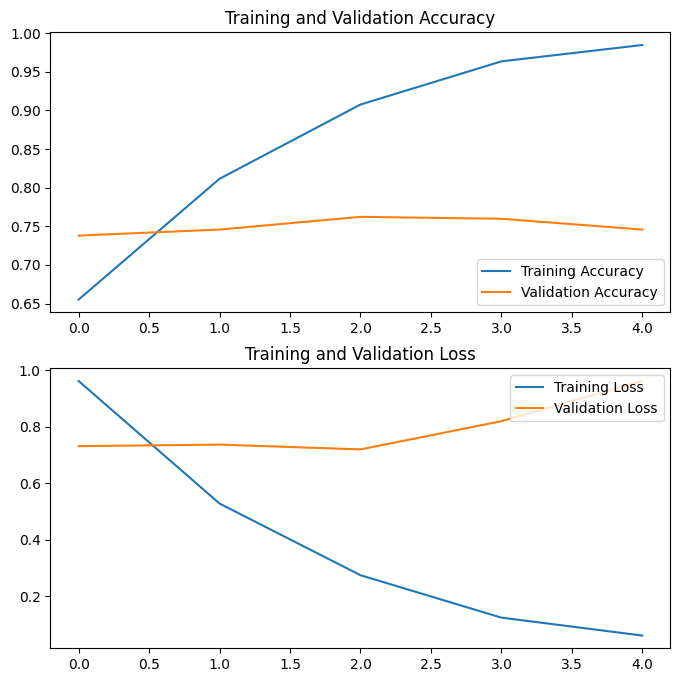

In [13]:
trainAccuracy = historyOriginal_nonAug.history['accuracy']
validationAccuracy = historyOriginal_nonAug.history['val_accuracy']

trainLoss = historyOriginal_nonAug.history['loss']
validationLoss = historyOriginal_nonAug.history['val_loss']

epochsRange = range(len(trainAccuracy))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochsRange, trainAccuracy, label='Training Accuracy')
plt.plot(epochsRange, validationAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochsRange, trainLoss, label='Training Loss')
plt.plot(epochsRange, validationLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model 1 - Using augmented data. --> BEST MODEL.

In [34]:
model1 = keras.Sequential()
model1.add(keras.layers.Rescaling(1./255, input_shape=(imgHeight, imgWidth,3)))

#CV1 with 32 filters, each of size of 5x5. ReLU activation function.
model1.add(keras.layers.Conv2D(32, (5,5), activation='relu'))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.MaxPooling2D(4,4))

#CV2
model1.add(keras.layers.Conv2D(64, (5,5), activation='relu'))
model1.add(keras.layers.BatchNormalization())

#CV3
model1.add(keras.layers.Conv2D(128, (5,5), activation='relu'))
model1.add(keras.layers.MaxPooling2D(4,4))

#Flattens the output into a one-dimensional array.
model1.add(keras.layers.Flatten())
model1.add(keras.layers.Dense(128, activation='relu'))
model1.add(keras.layers.Dropout(0.25))
model1.add(keras.layers.Dense(6, activation='softmax'))
           
#Compile model
opt = Adam(learning_rate = 0.0001)  #Set learning rate 
model1.compile(optimizer=opt, loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [31]:
#Print model summary to ensure
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 146, 146, 32)      2432      
                                                                 
 batch_normalization_7 (Batc  (None, 146, 146, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        51264     
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 64)      

In [35]:
#Fit the model. Train for 10 epochs.
history1_Aug = model1.fit(trainData2, epochs=10, validation_data=validationData2)

Epoch 1/10
350/350 [==============================] - 18s 44ms/step - loss: 1.1314 - accuracy: 0.5639 - val_loss: 1.2194 - val_accuracy: 0.5016
Epoch 2/10
350/350 [==============================] - 15s 42ms/step - loss: 0.8865 - accuracy: 0.6671 - val_loss: 0.7651 - val_accuracy: 0.7201
Epoch 3/10
350/350 [==============================] - 15s 42ms/step - loss: 0.8074 - accuracy: 0.7026 - val_loss: 0.6935 - val_accuracy: 0.7562
Epoch 4/10
350/350 [==============================] - 15s 42ms/step - loss: 0.7318 - accuracy: 0.7320 - val_loss: 0.6720 - val_accuracy: 0.7701
Epoch 5/10
350/350 [==============================] - 15s 44ms/step - loss: 0.7004 - accuracy: 0.7439 - val_loss: 0.6655 - val_accuracy: 0.7715
Epoch 6/10
350/350 [==============================] - 15s 41ms/step - loss: 0.6600 - accuracy: 0.7552 - val_loss: 0.8178 - val_accuracy: 0.7008
Epoch 7/10
350/350 [==============================] - 15s 43ms/step - loss: 0.6411 - accuracy: 0.7667 - val_loss: 0.6319 - val_accuracy:

### 1st model - Visualize Training (accuracy and loss)

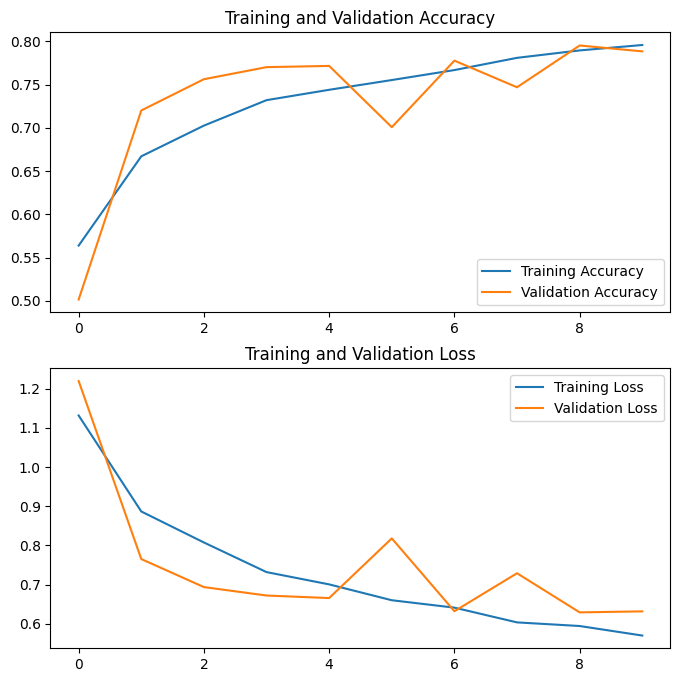

In [36]:
trainAccuracy = history1_Aug.history['accuracy']
validationAccuracy = history1_Aug.history['val_accuracy']

trainLoss = history1_Aug.history['loss']
validationLoss = history1_Aug.history['val_loss']

epochsRange = range(len(trainAccuracy))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochsRange, trainAccuracy, label='Training Accuracy')
plt.plot(epochsRange, validationAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochsRange, trainLoss, label='Training Loss')
plt.plot(epochsRange, validationLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model 2 - Using augmented data.

In [18]:
model2 = keras.Sequential()
#Scales the pixel values of input images to the range [0, 1]. input_shape parameter specifies the size.
model2.add(keras.layers.Rescaling(1./255, input_shape=(imgHeight, imgWidth,3)))

#CV1
model2.add(keras.layers.Conv2D(32, (5,5), activation='relu', strides=2, padding='same'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.MaxPooling2D(2,2))

#CV2
model2.add(keras.layers.Conv2D(64, (5,5), activation='relu'))
model2.add(keras.layers.BatchNormalization())

#CV3
model2.add(keras.layers.Conv2D(128, (5,5), activation='relu', strides=2, padding='same'))
model2.add(keras.layers.MaxPooling2D(2,2))

#Flattens the output into a one-dimensional array.
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(128, activation='relu'))
model2.add(keras.layers.Dropout(0.25))
model2.add(keras.layers.Dense(6, activation='softmax'))

#Compile model
opt = Adam(learning_rate = 0.0001)  #Set learning rate 
model2.compile(optimizer=opt, loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [19]:
#Print model summary to ensure
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 32)        2432      
                                                                 
 batch_normalization_2 (Batc  (None, 75, 75, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 33, 33, 64)        51264     
                                                                 
 batch_normalization_3 (Batc  (None, 33, 33, 64)      

In [20]:
#Fit the model. Train for 5 epochs.
history2_Aug = model2.fit(trainData2, epochs=10, validation_data=validationData2)

Epoch 1/10
350/350 [==============================] - 18s 42ms/step - loss: 1.0913 - accuracy: 0.5782 - val_loss: 1.7030 - val_accuracy: 0.3983
Epoch 2/10
350/350 [==============================] - 15s 41ms/step - loss: 0.8885 - accuracy: 0.6670 - val_loss: 0.7495 - val_accuracy: 0.7261
Epoch 3/10
350/350 [==============================] - 15s 42ms/step - loss: 0.7871 - accuracy: 0.7083 - val_loss: 0.8215 - val_accuracy: 0.7083
Epoch 4/10
350/350 [==============================] - 15s 42ms/step - loss: 0.7437 - accuracy: 0.7258 - val_loss: 0.6401 - val_accuracy: 0.7787
Epoch 5/10
350/350 [==============================] - 14s 41ms/step - loss: 0.7021 - accuracy: 0.7431 - val_loss: 0.6443 - val_accuracy: 0.7730
Epoch 6/10
350/350 [==============================] - 15s 42ms/step - loss: 0.6674 - accuracy: 0.7558 - val_loss: 0.6060 - val_accuracy: 0.7780
Epoch 7/10
350/350 [==============================] - 15s 41ms/step - loss: 0.6515 - accuracy: 0.7683 - val_loss: 0.5613 - val_accuracy:

### 2nd model - Visualize Training (accuracy and loss)

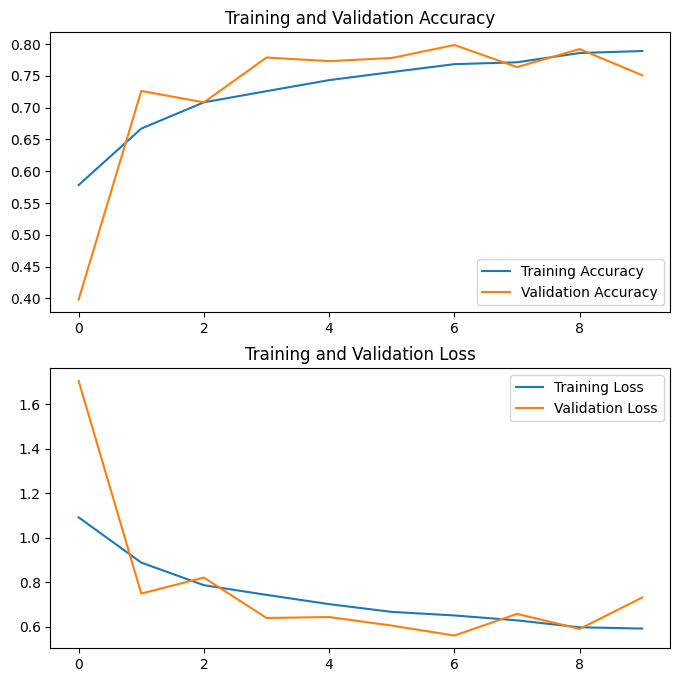

In [21]:
trainAccuracy = history2_Aug.history['accuracy']
validationAccuracy = history2_Aug.history['val_accuracy']

trainLoss = history2_Aug.history['loss']
validationLoss = history2_Aug.history['val_loss']

epochsRange = range(len(trainAccuracy))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochsRange, trainAccuracy, label='Training Accuracy')
plt.plot(epochsRange, validationAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochsRange, trainLoss, label='Training Loss')
plt.plot(epochsRange, validationLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model 3 - Using augmented data.

In [22]:
model3 = keras.Sequential()

model3.add(keras.layers.Rescaling(1./255, input_shape=(imgHeight, imgWidth,3)))

#CV1
model3.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.MaxPooling2D(2,2))

#CV2
model3.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model3.add(keras.layers.BatchNormalization())

#CV3
model3.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.MaxPooling2D(2,2))
           
#Flattens the output into a one-dimensional array.
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(128, activation='relu'))
model3.add(keras.layers.Dropout(0.2))
model3.add(keras.layers.Dense(64, activation='relu'))
model3.add(keras.layers.Dense(6, activation='softmax'))

#Compile model
opt = Adam(learning_rate = 0.0001)  #Set learning rate 
model3.compile(optimizer=opt, loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [23]:
#Print model summary to ensure
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 148, 148, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 72, 72, 64)      

In [24]:
#Fit the model.  Train for 10 epochs.
history3_Aug = model3.fit(trainData2, epochs=10, validation_data=validationData2)

Epoch 1/10
350/350 [==============================] - 20s 46ms/step - loss: 1.5338 - accuracy: 0.4906 - val_loss: 1.3358 - val_accuracy: 0.5288
Epoch 2/10
350/350 [==============================] - 16s 44ms/step - loss: 1.2215 - accuracy: 0.5541 - val_loss: 0.9889 - val_accuracy: 0.6396
Epoch 3/10
350/350 [==============================] - 15s 44ms/step - loss: 1.1605 - accuracy: 0.5790 - val_loss: 1.1220 - val_accuracy: 0.6139
Epoch 4/10
350/350 [==============================] - 16s 44ms/step - loss: 1.1212 - accuracy: 0.5985 - val_loss: 1.2953 - val_accuracy: 0.5928
Epoch 5/10
350/350 [==============================] - 16s 44ms/step - loss: 1.0980 - accuracy: 0.5949 - val_loss: 0.9742 - val_accuracy: 0.6607
Epoch 6/10
350/350 [==============================] - 16s 44ms/step - loss: 1.0632 - accuracy: 0.6139 - val_loss: 0.8610 - val_accuracy: 0.7093
Epoch 7/10
350/350 [==============================] - 16s 44ms/step - loss: 1.0193 - accuracy: 0.6252 - val_loss: 1.2605 - val_accuracy:

### 3rd model - Visualize Training (accuracy and loss)

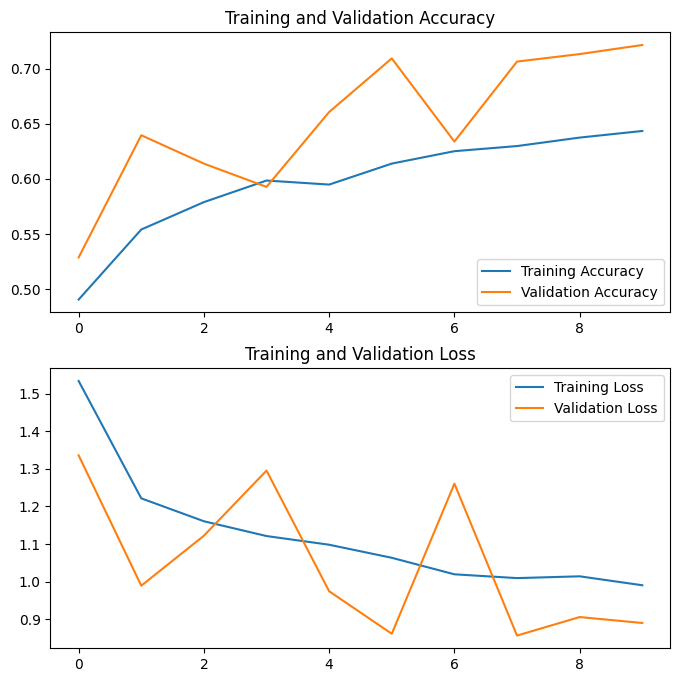

In [25]:
trainAccuracy = history3_Aug.history['accuracy']
validationAccuracy = history3_Aug.history['val_accuracy']

trainLoss = history3_Aug.history['loss']
validationLoss = history3_Aug.history['val_loss']

epochsRange = range(len(trainAccuracy))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochsRange, trainAccuracy, label='Training Accuracy')
plt.plot(epochsRange, validationAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochsRange, trainLoss, label='Training Loss')
plt.plot(epochsRange, validationLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Best model: 1st model. Examine the results for some validation examples.

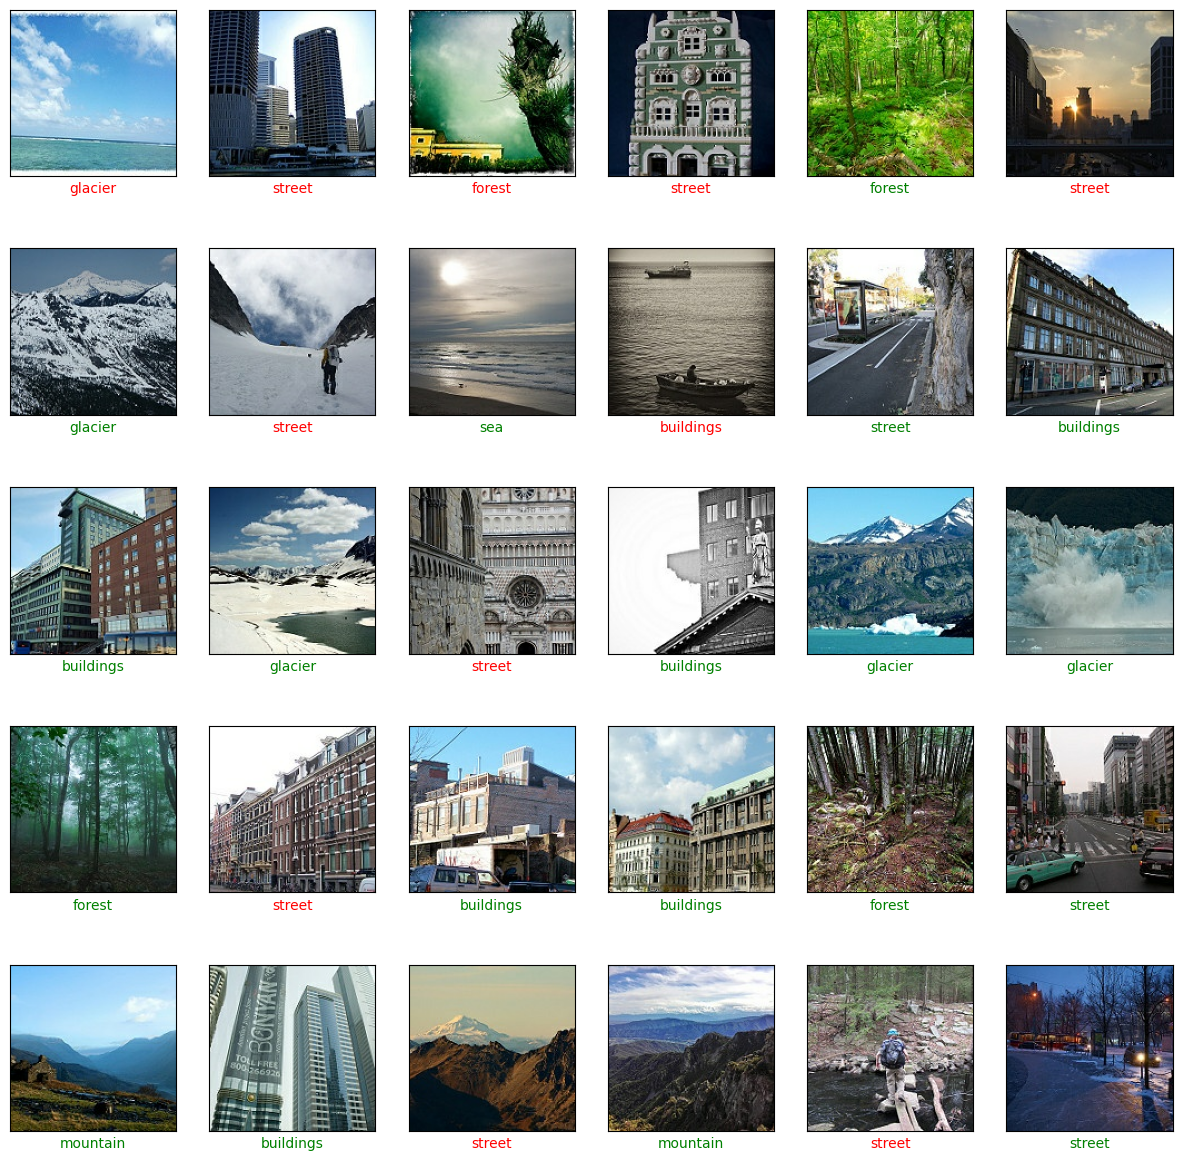

In [26]:
#Visualize 30 of the predicted data with green label for correct predictions.
#and red label vise versa.
plt.figure(figsize=(15,15))
for images, labels in validationData2.take(1):
    for i in range(30):
        prediction = model2.predict(images[i].numpy().reshape(1,imgHeight, imgWidth,3), verbose=0)
        plt.subplot(5, 6, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.grid(False)
        xlabel = plt.xlabel(classNames[prediction.argmax()])
        if (prediction.argmax() == labels[i].numpy().argmax()):
            xlabel.set_color("green")
        else:
            xlabel.set_color("red")
plt.show()

### Make Predictions for Test_Pred data.  
#### Note: Results are stored in a dictionary, which is keyed by file numbers (as integers).

In [27]:
#Load the test_pred data (which has no target labels)
import os
import cv2

predDirectory = '../input/csc-578-hw7-fall-2023/test_pred'
resultDict = {} #Dictionary to store predictions (keyed by file number)

print ("Predicting for 'test_pred' testset...")
#Iterate over files in that directory.
for filename in os.listdir(predDirectory):
    f = os.path.join(predDirectory, filename)
    #Checking if it is a file
    if os.path.isfile(f):
        fnum = int(filename[:-4]) #Filename e.g. '103.jpg" -> 103
        img = cv2.imread(f)
        img = img.reshape(-1,imgHeight, imgWidth,3)
        pred = model1.predict(img, verbose=0)
        resultDict[fnum] = pred[0]  # [0] because there is only one data
print (f'  -- done, {len(resultDict)} test instances predicted.')

Predicting for 'test_pred' testset...
  -- done, 2993 test instances predicted.


### Write the submission file, where the entries are sorted by the file number.

In [28]:
import csv

#Entries MUST be in the ascending order of the file names/numbers.
sortedResult = sorted(resultDict.items(), key=lambda x: x[0])
csvFile = 'HW7_1_Mai.csv'

with open(csvFile, 'w', newline='') as csvfile:
    #Write header.
    writer = csv.DictWriter(csvfile, fieldnames=['fnum', 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])
    writer.writeheader()

    #Write each row as a dictionary.
    for fnum, picPred in sortedResult:
        row = {'fnum': fnum, **{category: format(predValue, '.5f') for predValue, category in zip(picPred, ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])}}
        writer.writerow(row)

print(f'Predictions successfully saved to {csvFile}')

Predictions successfully saved to HW7_1_Mai.csv
